In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles
import pandas as pd
from scipy import interpolate

In [2]:
runName = 'carina_v1.7_10yrs'
dbFile = 'carina_v1.7_10yrs.db'
conn = db.OpsimDatabase(dbFile)
# Set the output directory
outDir = 'temp'
resultsDb = db.ResultsDb(outDir)

In [3]:
bundleList = []

# Grab everything
sql = ''

ra = np.array([ 160.])
dec = np.array([ -60.])
# Look at just one point on the sky
slicer = slicers.UserPointsSlicer(ra, dec)
# Pull out this information for visits that overlap that point
metric = metrics.PassMetric(cols=['observationStartMJD', 'fiveSigmaDepth', 'filter', 'note'])
plotDict={}
summaryStats = []
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql,
                                             plotDict=plotDict,
                                             summaryMetrics=summaryStats))
bg = metricBundles.MetricBundleGroup(bundleList, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()


Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'fiveSigmaDepth', 'note', 'filter', 'observationStartMJD', 'fieldDec'].
Found 2040123 visits
Running:  ['opsim_Pass_observationStartMJD_fiveSigmaDepth_filter_note_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


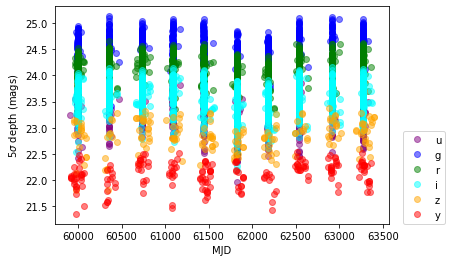

In [4]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
mv = bundleList[0].metricValues[0]
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
           'i': 'cyan', 'z': 'orange', 'y': 'red'}

for fn in f2c:
    in_filt = np.where(mv['filter'] == fn)[0]
    ax1.plot(mv['observationStartMJD'][in_filt],
             mv['fiveSigmaDepth'][in_filt], 'o',
             color=f2c[fn], label=fn, alpha=0.5)
ax1.set_xlabel('MJD')
ax1.set_ylabel(r'5$\sigma$ depth (mags)')
ax1.legend(loc=(1.04,0))

(59990.0, 60000.0)

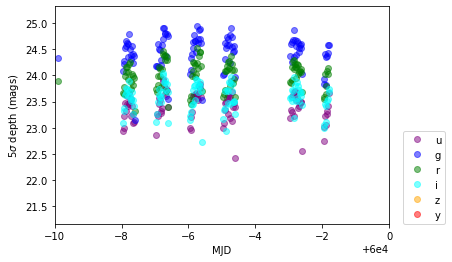

In [5]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
mv = bundleList[0].metricValues[0]
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
           'i': 'cyan', 'z': 'orange', 'y': 'red'}

for fn in f2c:
    in_filt = np.where(mv['filter'] == fn)[0]
    ax1.plot(mv['observationStartMJD'][in_filt],
             mv['fiveSigmaDepth'][in_filt], 'o',
             color=f2c[fn], label=fn, alpha=0.5)
ax1.set_xlabel('MJD')
ax1.set_ylabel(r'5$\sigma$ depth (mags)')
ax1.legend(loc=(1.04,0))
ax1.set_xlim([59990, 60000])

In [6]:
# here's what the data looks like
mv

array([(162.65318374, 22.24980394, 'blob, yy, a', 'y', 62872.29649573, -58.92587646),
       (162.65318374, 22.42114502, 'blob, yy, b', 'y', 62872.31230313, -58.92587646),
       (163.1156592 , 22.80257837, 'greedy', 'z', 63293.38096059, -59.57220069),
       ...,
       (158.14661959, 22.8913584 , 'greedy', 'z', 60799.96725182, -58.56143971),
       (158.37041094, 23.75839327, 'greedy', 'r', 60442.96512397, -58.55833478),
       (157.88608637, 23.68894135, 'blob, ri, b', 'i', 62152.31470625, -58.70332838)],
      dtype=(numpy.record, [('fieldRA', '<f8'), ('fiveSigmaDepth', '<f8'), ('note', '<U256'), ('filter', '<U256'), ('observationStartMJD', '<f8'), ('fieldDec', '<f8')]))

In [7]:
# dates of observations
mv.sort(order='observationStartMJD')
mv['observationStartMJD']

array([59904.3392548 , 59916.33531727, 59916.33621801, ...,
       63379.99587456, 63401.96373811, 63401.96509835])

In [8]:
# Let's read in the light curve
names = ['HJD', 'mag', 'band']
types = [float, float, "|U1"]
dtype = list(zip(names, types))
lc_data =np.genfromtxt('source0603396438_whole_CoRoT_LC_NEW_sampled.dat', dtype=dtype)

Text(0.5, 1.0, 'input lc')

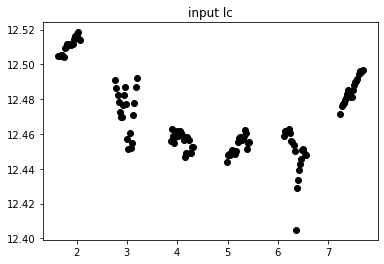

In [9]:
plt.plot(lc_data['HJD'], lc_data['mag'], 'ko')
plt.title('input lc')

In [10]:
in_filt = np.where(mv['filter'] == 'r')
mv['observationStartMJD'][in_filt]

array([59960.33065789, 59960.33816496, 59962.31210784, ...,
       63331.06679238, 63336.125254  , 63367.04256599])

Text(0, 0.5, 'Interpolated mags')

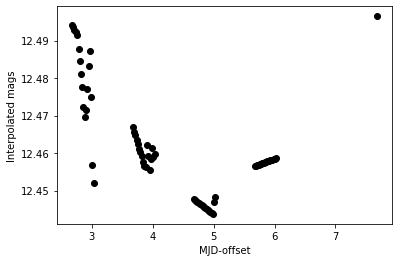

In [11]:
interp = interpolate.interp1d(lc_data['HJD'], lc_data['mag'], fill_value=np.nan)
t = mv['observationStartMJD'][in_filt]-59991 + lc_data['HJD'].min()
t=t[np.where( (t <= lc_data['HJD'].max()) & (t >= lc_data['HJD'].min()) ) ]
lsst_sampled = interp(t)

plt.plot(t, lsst_sampled, 'ko')
plt.xlabel('MJD-offset')
plt.ylabel('Interpolated mags')

In [12]:
# Let's just fold it up
t = mv['observationStartMJD'][in_filt] % (lc_data['HJD'].max()-lc_data['HJD'].min()) 
t += lc_data['HJD'].min()

Text(0, 0.5, 'Interpolated mags')

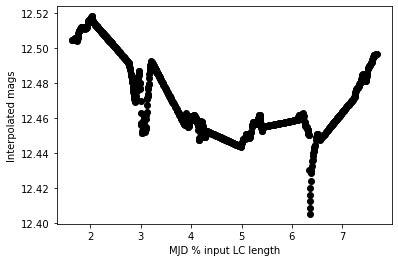

In [13]:
lsst_sampled = interp(t)

plt.plot(t, lsst_sampled, 'ko')
plt.xlabel('MJD % input LC length')
plt.ylabel('Interpolated mags')